# BERTSurv From Scratch: Survival Modeling on Clinical Text with Explainability

This notebook (exported as a single Markdown file) demonstrates a complete, reproducible pipeline for survival prediction from unstructured text using a **BERTSurv-style model**, including:

- **Data generation** with varied train/test splits  
- A **BERT encoder + Cox head** trained with a partial likelihood loss  
- **Concordance index (C-index)** evaluation  
- **Baseline survival estimation** and **individual survival curves**  
- **SHAP explainability** at the token level  
- **WordPiece stitching** and **stopword filtering** for human-readable SHAP outputs  
- A simple **dashboard** for multi-patient comparison and **group Kaplan–Meier visualization**

---

## Notes

- This is a **teaching notebook**. The data here are **synthetic** and for demonstration.  
- The BERT model and SHAP can be **slow on CPU**; a **GPU runtime** is recommended.  
- The Cox loss used is the **common minibatch approximation** for demonstration.  
  For research, consider **full-risk set handling** or libraries like [`pycox`](https://github.com/havakv/pycox).


In [1]:
# If running in Jupyter/Colab, uncomment the next line.
# !pip install torch transformers lifelines shap scikit-learn pandas matplotlib numpy -q


In [2]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.model_selection import train_test_split
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter, KaplanMeierFitter

from transformers import AutoTokenizer, AutoModel

import shap
import re


/opt/anaconda3/envs/bert-serv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Create a Varied Synthetic Dataset (Text + Survival Outcomes)

We generate semi-realistic clinical notes with **risk drivers**:

- Age  
- Smoker  
- COPD  
- Diabetes  
- Hypertension  
- Cancer stage  
- Activity level

Event times are simulated from an **exponential distribution** whose rate depends on the **latent linear predictor**. This gives us a varied dataset for training and testing.


In [3]:
import math
import random
import numpy as np
import pandas as pd

random.seed(42)
np.random.seed(42)

AGES = list(range(40, 101))                 
SEX = ["male", "female"]
SMOKER = ["smoker", "non-smoker"]
COPD = [True, False]
DM = [True, False]                          
HTN = [True, False]                         
CANCER_STAGE = ["none", "I", "II", "III"]
ACTIVITY = ["sedentary", "moderate", "active"]

def synth_note():
    age = random.choice(AGES)
    sex = random.choice(SEX)
    smoker = random.choice(SMOKER)
    copd = random.choice(COPD)
    dm = random.choice(DM)
    htn = random.choice(HTN)
    stage = random.choice(CANCER_STAGE)
    activity = random.choice(ACTIVITY)

    # Multi-line diagnostic note (≥5 lines)
    lines = [
        f"Patient is a {age}-year-old {sex} with {smoker} status.",
        f"Respiratory history: {'COPD diagnosis' if copd else 'no COPD'}.",
        f"Metabolic status: {'diabetes' if dm else 'no diabetes'}, "
        f"{'hypertension' if htn else 'no hypertension'}.",
        f"Oncology status: {'cancer stage ' + stage if stage != 'none' else 'no cancer'}.",
        f"Lifestyle assessment: {activity} lifestyle.",
        "Follow-up recommended to monitor comorbidities and progression risk."
    ]
    text = "\n".join(lines)
    return text, age, sex, smoker, copd, dm, htn, stage, activity

def latent_risk(age, sex, smoker, copd, dm, htn, stage, activity):
    """Linear predictor for hazard (higher = riskier, shorter survival)."""
    beta_age = 0.03  # stronger penalty for age
    beta_male = 0.3 if sex == "male" else 0.0   # male disadvantage
    beta_smoker = 0.8 if smoker == "smoker" else -0.2  # smoker worse, non-smoker slightly better
    beta_copd = 0.6 if copd else 0.0
    beta_dm = 0.4 if dm else 0.0
    beta_htn = 0.3 if htn else 0.0
    beta_stage = {"none": 0.0, "I": 0.5, "II": 1.0, "III": 1.5}[stage]
    beta_act = {"sedentary": 0.4, "moderate": 0.0, "active": -0.3}[activity]

    lin = (
        beta_age * age
        + beta_male
        + beta_smoker
        + beta_copd
        + beta_dm
        + beta_htn
        + beta_stage
        + beta_act
    )
    return lin

def simulate_dataset(n=600, cap_years=30):
    rows = []
    baseline_hazard = 0.003  # overall hazard scale
    for _ in range(n):
        note, age, sex, smoker, copd, dm, htn, stage, activity = synth_note()
        lin = latent_risk(age, sex, smoker, copd, dm, htn, stage, activity)
        rate = baseline_hazard * math.exp(lin / 50.0)  
        time_years = np.random.exponential(1.0 / rate)
        time_years = min(time_years, cap_years)
        event = np.random.binomial(1, 0.75)  # 75% observed
        rows.append((note, round(time_years, 2), event))
    return pd.DataFrame(rows, columns=["note", "time", "event"])

# Generate dataset
data = simulate_dataset(n=20, cap_years=20)
print(data.iloc[0]["note"])
print(data.head(5))


Patient is a 80-year-old male with smoker status.
Respiratory history: no COPD.
Metabolic status: diabetes, hypertension.
Oncology status: cancer stage I.
Lifestyle assessment: active lifestyle.
Follow-up recommended to monitor comorbidities and progression risk.
                                                note   time  event
0  Patient is a 80-year-old male with smoker stat...  20.00      0
1  Patient is a 46-year-old male with non-smoker ...  20.00      1
2  Patient is a 72-year-old male with smoker stat...  20.00      1
3  Patient is a 88-year-old male with non-smoker ...  18.58      0
4  Patient is a 46-year-old male with non-smoker ...  20.00      1


### Train/Test Split

In [4]:
train_df, test_df = train_test_split(
    data, test_size=0.25, random_state=42, stratify=data["event"]
)
len(train_df), len(test_df), train_df["event"].mean(), test_df["event"].mean()


(15, 5, np.float64(0.7333333333333333), np.float64(0.6))

## Tokenizer and Dataset Class

We use a BERT tokenizer and a simple Dataset that returns token IDs, masks, and survival targets.

In [5]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

class TextSurvDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=96):
        self.texts = df["note"].tolist()
        self.times = df["time"].astype(np.float32).values
        self.events = df["event"].astype(np.float32).values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            return_tensors="pt",
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
        )
        item = {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "time": torch.tensor(self.times[idx], dtype=torch.float32),
            "event": torch.tensor(self.events[idx], dtype=torch.float32),
            "text": self.texts[idx],
        }
        return item

train_ds = TextSurvDataset(train_df, tokenizer)
test_ds = TextSurvDataset(test_df, tokenizer)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, drop_last=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, drop_last=False)


## BERTSurv Model (BERT + Linear Cox Head)

The model outputs a log-risk score per input.

In [6]:
class BERTSurv(nn.Module):
    def __init__(self, model_name="bert-base-uncased", dropout=0.2):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.head = nn.Linear(self.encoder.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls = out.last_hidden_state[:, 0, :]
        cls = self.dropout(cls)
        risk = self.head(cls).squeeze(-1)  # log-risk
        return risk


## 6. Cox Partial Likelihood Loss (Minibatch Approximation)

For pedagogy, we use a standard minibatch approximation:

In [7]:
def cox_partial_loglik(risk, time, event):
    # Sort by descending time so risk set is cumulative forward
    order = torch.argsort(time, descending=True)
    risk = risk[order]
    event = event[order]
    # logsumexp cumulative of risks
    log_cum_hazard = torch.logcumsumexp(risk, dim=0)
    # partial log-likelihood contribution
    pll = risk - log_cum_hazard
    # only failures contribute
    return -torch.sum(pll * event) / (torch.sum(event) + 1e-8)


## Training Loop

For demonstration we train a few epochs; increase for better performance.

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTSurv().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

def train_epoch(loader, model, optimizer):
    model.train()
    total_loss = 0.0
    total_events = 0.0
    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        time = batch["time"].to(device)
        event = batch["event"].to(device)

        optimizer.zero_grad()
        risk = model(input_ids, attention_mask)
        loss = cox_partial_loglik(risk, time, event)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * event.size(0)
        total_events += event.size(0)
    return total_loss / max(total_events, 1)

for epoch in range(3):
    tr_loss = train_epoch(train_loader, model, optimizer)
    print(f"Epoch {epoch+1}: train loss = {tr_loss:.4f}")


Epoch 1: train loss = 1.7463
Epoch 2: train loss = 1.7284
Epoch 3: train loss = 1.7624


# Evaluation: C-index on Test Set

We compute the concordance index using predicted risk scores. In Cox models, larger log-risk implies higher hazard, so we pass -risk to concordance_index as scores where larger indicates longer survival.

In [9]:
model.eval()
all_time, all_event, all_risk = [], [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        risk = model(input_ids, attention_mask).cpu().numpy()
        all_risk.extend(risk.tolist())
        all_time.extend(batch["time"].numpy().tolist())
        all_event.extend(batch["event"].numpy().tolist())

all_time = np.array(all_time)
all_event = np.array(all_event).astype(bool)
all_risk = np.array(all_risk)

# C-index: larger predicted score implies longer survival, so use -risk
cindex = concordance_index(all_time, -all_risk, all_event)
print(f"Test C-index: {cindex:.3f}")


Test C-index: 0.667


## Baseline Survival and Individual Survival Curves

To get a baseline survival curve, we fit a Cox model in lifelines using the BERT-predicted risk scores as a single covariate on the training set. This gives a Breslow baseline survival estimate we can use for individuals.

Patient log-risk: 0.295


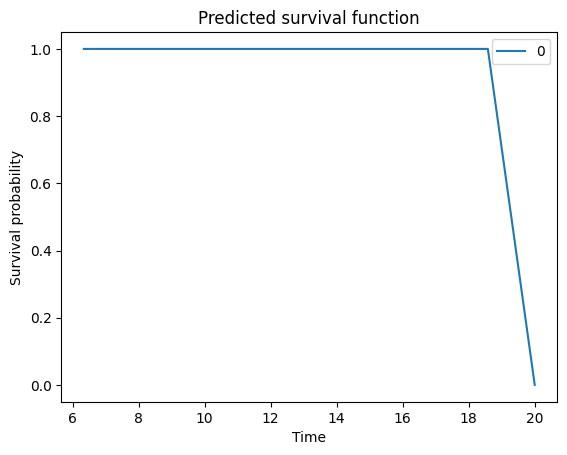

In [10]:
# Compute train-set risks
model.eval()
train_risks = []
with torch.no_grad():
    for batch in DataLoader(train_ds, batch_size=64, shuffle=False):
        ids = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        r = model(ids, mask).cpu().numpy()
        train_risks.extend(r.tolist())

train_risks = np.array(train_risks)
cox_df = pd.DataFrame({
    "risk_lp": train_risks,               # linear predictor from BERTSurv
    "time": train_df["time"].values,
    "event": train_df["event"].values
})

cph = CoxPHFitter()
cph.fit(cox_df, duration_col="time", event_col="event")

# Example patient survival curve from baseline + lp
def predict_survival_from_text(text, times=None):
    enc = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=96)
    with torch.no_grad():
        r = model(enc["input_ids"].to(device), enc["attention_mask"].to(device)).cpu().numpy()[0]
    row = pd.DataFrame({"risk_lp": [r]})
    sf = cph.predict_survival_function(row)
    if times is not None:
        sf = sf.loc[sf.index.intersection(times)]
    return r, sf

patient_text = "72-year-old male, smoker, COPD diagnosis, sedentary lifestyle, cancer stage II"
risk_score, surv_fn = predict_survival_from_text(patient_text)

print(f"Patient log-risk: {risk_score:.3f}")
surv_fn.plot(title="Predicted survival function")
plt.xlabel("Time")
plt.ylabel("Survival probability")
plt.show()


## SHAP Explainability on Text

We will use SHAP to attribute the predicted risk to tokens. Then we will post-process tokens to stitch WordPiece fragments, remove stopwords and punctuation, and aggregate to whole words.

Helper: Model Wrapper for SHAP

In [11]:
model.eval()

def model_wrapper(texts):
    """
    SHAP-compatible wrapper that returns model log-risk for a list of raw texts.
    """
    if isinstance(texts, str):
        texts = [texts]
    elif isinstance(texts, np.ndarray):
        texts = texts.tolist()
    elif not isinstance(texts, list):
        texts = [str(texts)]

    cleaned = []
    for t in texts:
        if t is None:
            cleaned.append("")
        elif isinstance(t, (int, float)):
            cleaned.append(str(t))
        else:
            cleaned.append(str(t).strip())

    tokens = tokenizer(
        cleaned, return_tensors="pt", padding=True, truncation=True, max_length=96
    )
    with torch.no_grad():
        risk = model(tokens["input_ids"].to(device), tokens["attention_mask"].to(device))
    return risk.detach().cpu().numpy().flatten()


In [12]:
masker = shap.maskers.Text(tokenizer)
explainer = shap.Explainer(model_wrapper, masker)


## Stopword Set and WordPiece Aggregation

We will collapse subword tokens (WordPiece, denoted by ##) into full words, merge hyphenated constructions, and drop common stopwords and punctuation so the explanation table is readable.

In [13]:
import re
import numpy as np
import pandas as pd
from collections import defaultdict

# Basic English stopword list (extend as needed)
STOPWORDS = set("""
a an the and or but if while of in on at to for from with without within not no
is are was were be been being am do does did have has had having can could should
would may might will shall as by about into over under again further then once
here there when where why how all any both each few more most other some such nor
than too very s t d ll m o re ve y
""".split())

# Treat hyphen as part of words when between alphanumerics, e.g. "72-year-old"
WORD_RE = re.compile(r"[A-Za-z0-9]+(?:-[A-Za-z0-9]+)*")

# Special tokens to ignore if offsets are present (offsets (0,0) are also ignored)
SPECIAL_IDS = None  # will be set from tokenizer if provided


def _roman_numeral(s: str) -> bool:
    """Return True if s is a small roman numeral (useful to filter 'ii', 'iii' if desired)."""
    return bool(s) and len(s) <= 4 and re.fullmatch(r"[ivxlcdm]+", s) is not None


def aggregate_shap_by_words(
    expl,
    raw_text: str,
    tokenizer,
    *,
    remove_stopwords: bool = True,
    drop_roman_numerals: bool = False,
    min_word_len: int = 2,
    keep_short: set = frozenset({"copd", "dm", "htn"}),  # keep key clinical short terms
    top_n: int = 20,
    debug: bool = False,
):
    """
    Aggregate SHAP values from subword tokens to real words using tokenizer offset mappings.

    How it works
    ------------
    1) Tokenize raw_text with `return_offsets_mapping=True` to get char spans per token.
    2) Build word spans from the original text via a hyphen-aware regex.
    3) For each token, add its SHAP value to the word with the largest character-span overlap.
    4) Filter stopwords, optional roman numerals, and very short words (except allowlisted).
    5) Return a ranked DataFrame of word-level impacts.

    This avoids any hardcoded “se+dent+ary → sedentary” rules and will correctly merge
    fragments like ('cop', '##d') or ('se','dent','ary') because they map to the same
    original word via character offsets.
    """
    # 1) Tokenize with offsets
    enc = tokenizer(
        raw_text,
        return_offsets_mapping=True,
        add_special_tokens=True,
        truncation=True,
        max_length=512,
    )
    offsets = enc["offset_mapping"]
    input_ids = enc["input_ids"]
    tokens = tokenizer.convert_ids_to_tokens(input_ids, skip_special_tokens=False)

    # Initialize SPECIAL_IDS once (CLS, SEP, PAD, etc.)
    global SPECIAL_IDS
    if SPECIAL_IDS is None:
        SPECIAL_IDS = set(
            tid for name in ["cls_token_id", "sep_token_id", "pad_token_id", "unk_token_id"]
            if hasattr(tokenizer, name) and (tid := getattr(tokenizer, name)) is not None
        )

    # SHAP tokenization (masker) typically matches tokenizer tokens with specials removed.
    shap_tokens = list(expl.data)
    shap_vals = np.array(expl.values)

    # Remove specials by offset (0,0) and by special IDs
    keep_idx = []
    for i, (s, e) in enumerate(offsets):
        if s == 0 and e == 0:
            continue
        if SPECIAL_IDS and input_ids[i] in SPECIAL_IDS:
            continue
        keep_idx.append(i)

    tok_kept = [tokens[i] for i in keep_idx]
    off_kept = [offsets[i] for i in keep_idx]

    # Align lengths: SHAP tokens should match non-special tokens. If not, fail loudly.
    if len(shap_tokens) != len(tok_kept):
        if debug:
            print(f"[WARN] Token length mismatch: shap={len(shap_tokens)} vs kept={len(tok_kept)}")
            print("shap tokens:", shap_tokens)
            print("tok_kept   :", tok_kept)
        # Best-effort fallback: truncate to the common prefix length
        L = min(len(shap_tokens), len(tok_kept))
        shap_tokens, shap_vals = shap_tokens[:L], shap_vals[:L]
        tok_kept, off_kept = tok_kept[:L], off_kept[:L]

    # 2) Build word spans from the original text
    words = [(m.group(), m.start(), m.end()) for m in WORD_RE.finditer(raw_text)]
    if not words:
        # If nothing matched (unlikely), fall back to the whole text
        words = [(raw_text.strip(), 0, len(raw_text.strip()))] if raw_text.strip() else []

    # 3) Map each token to the word with maximum overlap
    word_scores = defaultdict(float)

    # Precompute for speed
    word_starts = [ws for _, ws, _ in words]
    word_ends = [we for _, _, we in words]

    def best_word_index(tok_span):
        s, e = tok_span
        best_i, best_overlap = -1, 0
        # Linear scan is fine for short notes; for very long text, use binary search around s/e.
        for i, (_, ws, we) in enumerate(words):
            overlap = max(0, min(e, we) - max(s, ws))
            if overlap > best_overlap:
                best_overlap, best_i = overlap, i
            # Small optimization: break if ws already beyond token end
            if ws > e:
                break
        return best_i, best_overlap

    for (s, e), val in zip(off_kept, shap_vals):
        if s >= e:  # skip empty spans
            continue
        i, ov = best_word_index((s, e))
        if i >= 0 and ov > 0:
            w = words[i][0].lower()
            word_scores[w] += float(val)

    # 4) Filter & tidy words
    rows = []
    for w, score in word_scores.items():
        if not w:
            continue
        if remove_stopwords and (w in STOPWORDS):
            continue
        if drop_roman_numerals and _roman_numeral(w):
            continue
        if len(w) < min_word_len and w not in keep_short:
            continue
        rows.append((w, score))

    # 5) Rank by absolute impact
    if not rows:
        return pd.DataFrame(columns=["token", "impact", "abs_impact"])

    df = pd.DataFrame(rows, columns=["token", "impact"])
    df["abs_impact"] = df["impact"].abs()
    df = df.sort_values("abs_impact", ascending=False).head(top_n).reset_index(drop=True)

    if debug:
        print("== DEBUG ==")
        print("Original text:\n", raw_text)
        print("\nTokenizer tokens (kept):")
        for t, (s, e) in zip(tok_kept, off_kept):
            print(f"{t:15s} [{s}:{e}] -> '{raw_text[s:e]}'")
        print("\nWord spans:")
        for w, s, e in words:
            print(f"{w:15s} [{s}:{e}]")
        print("\nWord scores:")
        print(df)

    return df


## Explain a Single Patient


Top influential tokens (aggregated):


,token,impact,abs_impact
0,sedentary,0.048454,0.048454
1,stage,0.041980,0.041980
2,72-year-old,0.040977,0.040977
3,smoker,0.035215,0.035215
4,male,0.024468,0.024468
5,copd,0.019801,0.019801
6,lifestyle,0.015942,0.015942
7,cancer,0.014709,0.014709
8,diagnosis,0.010256,0.010256


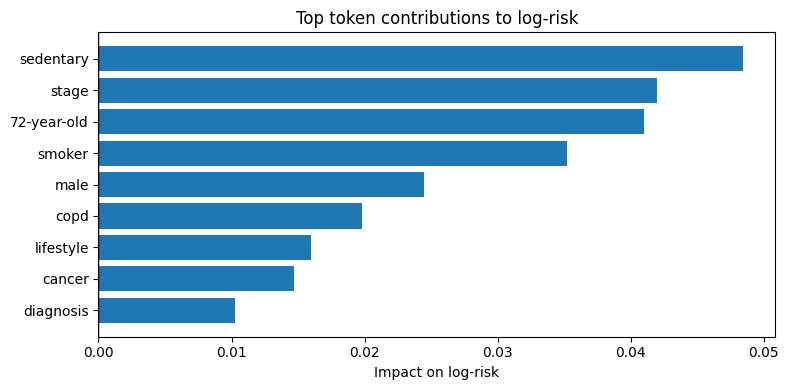

In [14]:
example_text = "72-year-old male, smoker, COPD diagnosis, sedentary lifestyle, cancer stage II"

# Compute SHAP
shap_values = explainer([example_text])

# Token-level visualization
shap.plots.text(shap_values[0])

# Aggregated table (correct call with raw_text and tokenizer)
clean_table = aggregate_shap_by_words(
    shap_values[0],
    raw_text=example_text,
    tokenizer=tokenizer,
    top_n=15,
    remove_stopwords=True,
    drop_roman_numerals=True
)

print("\nTop influential tokens (aggregated):")
display(clean_table)

# Optional bar plot of top tokens
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.barh(clean_table["token"][::-1], clean_table["impact"][::-1])
plt.axvline(0, color="black", linewidth=1)
plt.title("Top token contributions to log-risk")
plt.xlabel("Impact on log-risk")
plt.tight_layout()
plt.show()


## Multi-Patient Dashboard and Group Kaplan–Meier

This section provides convenience utilities to compare patients, generate SHAP explanations, and visualize group-level survival using a KM curve. For the KM curve, we simulate “observed” times from the risk scores for demonstration; in a real setting, you would compute curves from actual time-to-event data or from fitted Cox models per group.

In [15]:
def patient_risk(text: str) -> float:
    """Compute scalar risk score for a single patient note."""
    return float(model_wrapper([text])[0])


def explain_patient(
    text: str,
    tokenizer,
    show_shap_text: bool = False,
    top_n: int = 10,
    remove_stopwords: bool = True,
    drop_roman_numerals: bool = True
):
    """
    Explain risk prediction for a single patient.

    Args:
        text: Input patient note (string).
        tokenizer: HuggingFace tokenizer used by the model.
        show_shap_text: If True, show SHAP text visualization.
        top_n: How many top tokens to display.
        remove_stopwords: Whether to filter stopwords in aggregation.
        drop_roman_numerals: Whether to drop tokens like 'ii', 'iii'.

    Returns:
        dict with raw text, risk score, aggregated tokens, and SHAP explanation.
    """
    risk = patient_risk(text)
    exp = explainer([text])
    agg = aggregate_shap_by_words(
        exp[0],
        raw_text=text,
        tokenizer=tokenizer,
        top_n=top_n,
        remove_stopwords=remove_stopwords,
        drop_roman_numerals=drop_roman_numerals
    )
    if show_shap_text:
        shap.plots.text(exp[0])
    return {"text": text, "risk": risk, "tokens": agg, "shap": exp}


def compare_patients(
    patient_texts,
    high_thr: float = 0.7,
    mod_thr: float = 0.0
) -> pd.DataFrame:
    """
    Compare risk scores across patients.

    Args:
        patient_texts: List of patient notes.
        high_thr: Threshold for HIGH risk.
        mod_thr: Threshold for MODERATE risk.

    Returns:
        DataFrame with patient text, risk score, and risk level.
    """
    rows = []
    for t in patient_texts:
        r = patient_risk(t)
        level = "HIGH" if r > high_thr else ("MODERATE" if r > mod_thr else "LOW")
        rows.append({"text": t, "risk": r, "level": level})
    return pd.DataFrame(rows).sort_values("risk", ascending=False).reset_index(drop=True)


def plot_group_km(
    patient_texts,
    group_labels,
    tokenizer,
    time_horizon: int = 100
) -> pd.DataFrame:
    """
    Plot illustrative Kaplan–Meier curves for groups of patients.

    Args:
        patient_texts: List of patient notes.
        group_labels: List of group names (same length as patient_texts).
        tokenizer: HuggingFace tokenizer (needed for risk scoring).
        time_horizon: Controls pseudo-time scaling.

    Returns:
        DataFrame with text, group, risk, and pseudo survival time.
    """
    if len(group_labels) != len(patient_texts):
        raise ValueError("group_labels length must match patient_texts length")

    risks = [patient_risk(t) for t in patient_texts]

    # Higher risk -> shorter simulated survival
    times = [max(1.0, (1.5 - r) * time_horizon) for r in risks]
    events = [1] * len(times)

    kmf = KaplanMeierFitter()
    plt.figure(figsize=(7, 5))
    for g in sorted(set(group_labels)):
        idx = [i for i, gg in enumerate(group_labels) if gg == g]
        kmf.fit([times[i] for i in idx], [events[i] for i in idx], label=g)
        kmf.plot_survival_function()

    plt.title("Kaplan–Meier curves by group (illustrative)")
    plt.xlabel("Time")
    plt.ylabel("Survival probability")
    plt.grid(True, alpha=0.3)
    plt.show()

    return pd.DataFrame({"text": patient_texts, "group": group_labels, "risk": risks, "pseudo_time": times})


## Run the Dashboard

Patient risk ranking


,text,risk,level
0,"65-year-old male, smoker, diabetes, hypertensi...",0.532201,MODERATE
1,"55-year-old female, non-smoker, no COPD, no di...",0.425555,MODERATE
2,"50-year-old female, non-smoker, asthma history...",0.367093,MODERATE
3,"78-year-old male, smoker, COPD diagnosis, hype...",0.342782,MODERATE
4,"72-year-old male, smoker, COPD diagnosis, sede...",0.295178,MODERATE



Top tokens for first patient


,token,impact,abs_impact
0,sedentary,0.048454,0.048454
1,stage,0.041980,0.041980
2,72-year-old,0.040977,0.040977
3,smoker,0.035215,0.035215
4,male,0.024468,0.024468
5,copd,0.019801,0.019801
6,lifestyle,0.015942,0.015942
7,cancer,0.014709,0.014709
8,diagnosis,0.010256,0.010256


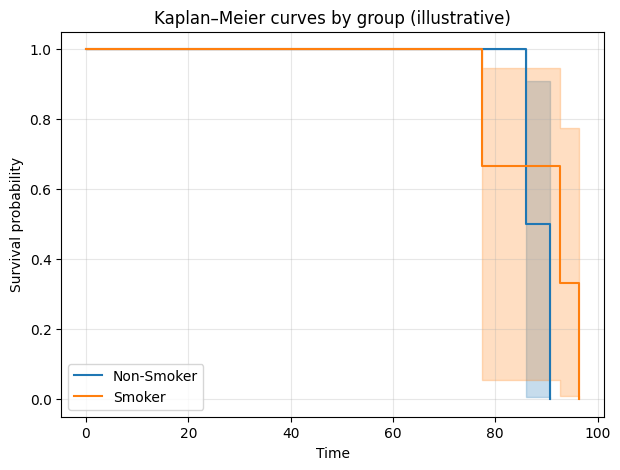


Group table


,text,group,risk,pseudo_time
0,"72-year-old male, smoker, COPD diagnosis, sede...",Smoker,0.295178,96.385775
1,"55-year-old female, non-smoker, no COPD, no di...",Non-Smoker,0.425555,85.955598
2,"65-year-old male, smoker, diabetes, hypertensi...",Smoker,0.532201,77.423949
3,"50-year-old female, non-smoker, asthma history...",Non-Smoker,0.367093,90.632551
4,"78-year-old male, smoker, COPD diagnosis, hype...",Smoker,0.342782,92.577465


In [17]:
patients = [
    "72-year-old male, smoker, COPD diagnosis, sedentary lifestyle, cancer stage II",
    "55-year-old female, non-smoker, no COPD, no diabetes, no hypertension, no cancer, active lifestyle",
    "65-year-old male, smoker, diabetes, hypertension, cancer stage I, moderate lifestyle",
    "50-year-old female, non-smoker, asthma history, no diabetes, no hypertension, no cancer, active lifestyle",
    "78-year-old male, smoker, COPD diagnosis, hypertension, cancer stage III, sedentary lifestyle",
]

groups = ["Smoker", "Non-Smoker", "Smoker", "Non-Smoker", "Smoker"]

# Rank by risk
summary_table = compare_patients(patients)
print("Patient risk ranking")
display(summary_table)

# Explain first patient with table
# Explain first patient with table
expl_0 = explain_patient(
    patients[0],
    tokenizer=tokenizer,   # <-- Add this
    show_shap_text=False,
    top_n=12
)
print("\nTop tokens for first patient")
display(expl_0["tokens"])

# Group KM (illustrative)
group_table = plot_group_km(patients, groups, tokenizer=tokenizer, time_horizon=80)
print("\nGroup table")
display(group_table)

